<a href="https://colab.research.google.com/github/Shallom12/myproject/blob/main/14_02_(final)_Word_Level_%EB%B2%88%EC%97%AD%EA%B8%B0_%EB%A7%8C%EB%93%A4%EA%B8%B0(Neural_Machine_Translation_(seq2seq)_Tutorial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2021년 12월 26일에 마지막으로 테스트 되었습니다.

이 자료는 위키독스 '딥 러닝을 이용한 자연어 처리 입문'의 단어 레벨 번역기의 튜토리얼 자료로서 만들어졌습니다.

원문 자료 : https://wikidocs.net/86900

# 14-02 Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial)
---
seq2seq를 이용해서 기계 번역기를 만들어보겠습니다. 시작하기에 앞서 참고하면 좋은 게시물을 소개합니다. 인터넷에 케라스로 seq2seq를 구현하는 많은 유사 예제들이 나와있지만 대부분은 케라스 개발자 프랑수아 숄레의 블로그의 유명 게시물인 'sequence-to-sequence 10분만에 이해하기'가 원본입니다. 이번 실습 또한 해당 게시물의 예제에 많이 영향받았습니다.

링크 : https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## 1. 데이터 로드 및 전처리
---
실제 성능이 좋은 기계 번역기를 구현하려면 방대한 데이터가 필요하므로 여기서는 seq2seq를 간단히 실습해보는 수준의 간단한 기계 번역기를 구현해보겠습니다. 기계 번역기를 훈련시키기 위해서는 훈련 데이터로 병렬 코퍼스(parallel corpus)가 필요합니다. 병렬 코퍼스란, 두 개 이상의 언어가 병렬적으로 구성된 코퍼스를 의미합니다.

링크 : http://www.manythings.org/anki

이번 실습에서는 프랑스어-영어 병렬 코퍼스인 fra-eng.zip 파일을 사용합니다. 위의 링크에서 해당 파일을 다운받은 후 압축을 풀면 fra.txt라는 파일을 얻을 수 있는데 해당 파일을이 실습에서 사용합니다.

병렬 코퍼스 데이터에 대해서 이해해봅시다. 병렬 데이터라고 하면 앞서 수행한 태깅 작업 챕터의 개체명 인식과 같은 데이터를 생각할 수 있지만, 앞서 수행한 태깅 작업의 병렬 데이터와 seq2seq가 사용하는 병렬 데이터는 성격이 다릅니다. 태깅 작업의 병렬 데이터는 쌍이 되는 데이터와 레이블이 길이가 동일하였으나 여기서는 쌍이 된다고 해서 반드시 길이가 같지는 않습니다.

실제 번역기를 생각해보면 구글 번역기에 '나는 학생이다.'라는 토큰의 개수가 2인 문장을 넣었을 때 'I am a student.'라는 토큰의 개수가 4인 문장이 나오는 것과 같은 이치입니다. seq2seq는 기본적으로 입력 시퀀스와 출력 시퀀스의 길이가 다를 수 있다고 가정합니다. 지금 구현 예제는 기계 번역기이지만 seq2seq로 구현할 수 있는 또 다른 예제인 챗봇을 만든다고 가정해보면, 대답의 길이가 질문의 길이와 항상 똑같아야 한다고하면 그 또한 이상합니다. 여기서 사용할 fra.txt 데이터는 아래와 같이 왼쪽의 영어 문장과 오른쪽의 프랑스어 문장 사이에 탭으로 구분되는 형식이 하나의 샘플입니다.

```Watch me.                    Regardez-moi !```          

데이터는 위와 동일한 형식의 약 19만개의 병렬 문장 샘플을 포함하고 있습니다. 데이터를 읽고 전처리를 진행해보겠습니다. 앞으로의 코드에서 src는 source의 줄임말로 입력 문장을 나타내며, tar는 target의 줄임말로 번역하고자 하는 문장을 나타냅니다.

In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tf.__version__  # 2024.08 tf 2.17.0

'2.17.0'

fra-eng.zip 파일을 다운로드하고 압축을 풀겠습니다.

In [ ]:
# http = urllib3.PoolManager()
# url ='http://www.manythings.org/anki/fra-eng.zip'
# filename = 'fra-eng.zip'
# path = os.getcwd()
# zipfilename = os.path.join(path, filename)
# with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
#     shutil.copyfileobj(r, out_file)

# with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
#     zip_ref.extractall(path)

이번 실습에서는 약 19만개의 데이터 중 33,000개의 샘플만을 사용할 예정입니다.

In [ ]:
num_samples = 33000

전처리 함수들을 구현합니다. 구두점 등을 제거하거나 단어와 구분해주기 위한 전처리입니다.

In [ ]:
# def unicode_to_ascii(s):
#     # 프랑스어 악센트(accent) 삭제
#     # 예시 : 'déjà diné' -> deja dine
#     return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [ ]:
def preprocess_sentence(sent, lang):
    # 악센트 삭제 함수 호출
    # sent = unicode_to_ascii(sent.lower())
    sent = sent.lower()

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    if lang == 'eng':
        sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    else:
        sent = re.sub(r"[^a-zA-ZÀ-ÿ!.?]+", r" ", sent)

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent

In [ ]:
# 파일 읽기 테스트
lines = open('fra. txt', 'r')
for i, line in enumerate(lines):
    src_line, tar_line, _ = line.strip().split('\t')
    print([src_line, tar_line, _])
    if i > 10:
        break
lines.close()

FileNotFoundError: [Errno 2] No such file or directory: 'fra. txt'

In [ ]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

#     with open("fra.txt", "r") as lines:   # cp949 encoding 에러!!
    with open("fra.txt", "r", encoding='utf8') as lines:
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line, 'eng').split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line,  'fra')
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [ ]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :', preprocess_sentence(en_sent, 'eng'))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent, 'fra'))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous déjà diné ?


In [ ]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

이렇게 얻은 3개의 데이터셋 인코더의 입력, 디코더의 입력, 디코더의 레이블을 상위 5개 샘플만 출력해봅시다.

In [ ]:
print('인코더의 입력 :', sents_en_in[:20])
print('디코더의 입력 :', sents_fra_in[:20])
print('디코더의 레이블 :',sents_fra_out[:20])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.'], ['<sos>', 'cours', '!'], ['<sos>', 'courez', '!'], ['<sos>', 'prenez', 'vos', 'jambes', 'à', 'vos', 'cous', '!'], ['<sos>', 'file', '!'], ['<sos>', 'filez', '!'], ['<sos>', 'cours', '!'], ['<sos>', 'fuyez', '!'], ['<sos>', 'fuyons', '!'], ['<sos>', 'cours', '!'], ['<sos>', 'courez', '!'], ['<sos>', 'prenez', 'vos', 'jambes', 'à', 'vos', 'cous', '!'], ['<sos>', 'file', '!'], ['<sos>', 'filez', '!'], ['<sos>', 'cours', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut

모델을 설계하기 전 의아한 점이 있을 수 있습니다. 현재 시점의 디코더 셀의 입력은 오직 이전 디코더 셀의 출력을 입력으로 받는다고 설명하였는데 디코더의 입력에 해당하는 데이터인 sents_fra_in이 왜 필요할까요?

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 합니다.

케라스 토크나이저를 통해 단어 집합을 생성, 정수 인코딩을 진행 후 이어서 패딩을 진행합니다.

In [ ]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)

In [ ]:
tokenizer_en.index_word

{1: '.',
 2: 'i',
 3: 'you',
 4: '?',
 5: 'tom',
 6: 'it',
 7: 'is',
 8: 's',
 9: 'a',
 10: 're',
 11: 'm',
 12: 'we',
 13: 't',
 14: 'the',
 15: 'that',
 16: 'he',
 17: 'was',
 18: 'me',
 19: 'this',
 20: 'they',
 21: 'are',
 22: 'to',
 23: '!',
 24: 'do',
 25: 'can',
 26: 'my',
 27: 'your',
 28: 'go',
 29: 'have',
 30: 'not',
 31: 'don',
 32: 'll',
 33: 'be',
 34: 'she',
 35: 'no',
 36: 'did',
 37: 'what',
 38: 'all',
 39: 'let',
 40: 'here',
 41: 'like',
 42: 'in',
 43: 'get',
 44: 'up',
 45: 'how',
 46: 'very',
 47: 'on',
 48: 'need',
 49: 'one',
 50: 'want',
 51: 'him',
 52: 'out',
 53: 'love',
 54: 'come',
 55: 'who',
 56: 'please',
 57: 'us',
 58: 'there',
 59: 'just',
 60: 'know',
 61: 'now',
 62: 'stop',
 63: 'so',
 64: 'of',
 65: 'got',
 66: 'too',
 67: 'help',
 68: 'look',
 69: 'take',
 70: 'good',
 71: 'for',
 72: 'has',
 73: 'at',
 74: 'see',
 75: 'will',
 76: 'were',
 77: 've',
 78: 'keep',
 79: 'had',
 80: 'am',
 81: 'back',
 82: 'give',
 83: 'feel',
 84: 'saw',
 85: 'tr

In [ ]:
tokenizer_en.word_index

{'.': 1,
 'i': 2,
 'you': 3,
 '?': 4,
 'tom': 5,
 'it': 6,
 'is': 7,
 's': 8,
 'a': 9,
 're': 10,
 'm': 11,
 'we': 12,
 't': 13,
 'the': 14,
 'that': 15,
 'he': 16,
 'was': 17,
 'me': 18,
 'this': 19,
 'they': 20,
 'are': 21,
 'to': 22,
 '!': 23,
 'do': 24,
 'can': 25,
 'my': 26,
 'your': 27,
 'go': 28,
 'have': 29,
 'not': 30,
 'don': 31,
 'll': 32,
 'be': 33,
 'she': 34,
 'no': 35,
 'did': 36,
 'what': 37,
 'all': 38,
 'let': 39,
 'here': 40,
 'like': 41,
 'in': 42,
 'get': 43,
 'up': 44,
 'how': 45,
 'very': 46,
 'on': 47,
 'need': 48,
 'one': 49,
 'want': 50,
 'him': 51,
 'out': 52,
 'love': 53,
 'come': 54,
 'who': 55,
 'please': 56,
 'us': 57,
 'there': 58,
 'just': 59,
 'know': 60,
 'now': 61,
 'stop': 62,
 'so': 63,
 'of': 64,
 'got': 65,
 'too': 66,
 'help': 67,
 'look': 68,
 'take': 69,
 'good': 70,
 'for': 71,
 'has': 72,
 'at': 73,
 'see': 74,
 'will': 75,
 'were': 76,
 've': 77,
 'keep': 78,
 'had': 79,
 'am': 80,
 'back': 81,
 'give': 82,
 'feel': 83,
 'saw': 84,
 'try': 

In [ ]:
tokenizer_en.word_counts

OrderedDict([('go', 815),
             ('.', 27846),
             ('hi', 14),
             ('run', 71),
             ('!', 1022),
             ('who', 319),
             ('?', 4153),
             ('wow', 5),
             ('duck', 4),
             ('fire', 17),
             ('help', 275),
             ('hide', 10),
             ('jump', 16),
             ('stop', 290),
             ('wait', 119),
             ('begin', 13),
             ('on', 426),
             ('hello', 16),
             ('i', 8791),
             ('see', 232),
             ('try', 187),
             ('won', 162),
             ('oh', 12),
             ('no', 627),
             ('relax', 23),
             ('smile', 17),
             ('sorry', 46),
             ('attack', 14),
             ('buy', 53),
             ('it', 3408),
             ('cheers', 4),
             ('eat', 144),
             ('get', 462),
             ('up', 445),
             ('now', 292),
             ('got', 279),
             ('hop', 2),
        

In [ ]:
tokenizer_en.document_count

33000

In [ ]:
sents_en_in[:10]

[['go', '.'],
 ['go', '.'],
 ['go', '.'],
 ['go', '.'],
 ['hi', '.'],
 ['hi', '.'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!']]

In [ ]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input[:10]

[[28, 1],
 [28, 1],
 [28, 1],
 [28, 1],
 [761, 1],
 [761, 1],
 [196, 23],
 [196, 23],
 [196, 23],
 [196, 23]]

In [ ]:
encoder_input = pad_sequences(encoder_input, padding="post")
encoder_input.shape, encoder_input[:10]

((33000, 8),
 array([[ 28,   1,   0,   0,   0,   0,   0,   0],
        [ 28,   1,   0,   0,   0,   0,   0,   0],
        [ 28,   1,   0,   0,   0,   0,   0,   0],
        [ 28,   1,   0,   0,   0,   0,   0,   0],
        [761,   1,   0,   0,   0,   0,   0,   0],
        [761,   1,   0,   0,   0,   0,   0,   0],
        [196,  23,   0,   0,   0,   0,   0,   0],
        [196,  23,   0,   0,   0,   0,   0,   0],
        [196,  23,   0,   0,   0,   0,   0,   0],
        [196,  23,   0,   0,   0,   0,   0,   0]], dtype=int32))

In [ ]:
sents_fra_in[:10]

[['<sos>', 'va', '!'],
 ['<sos>', 'marche', '.'],
 ['<sos>', 'en', 'route', '!'],
 ['<sos>', 'bouge', '!'],
 ['<sos>', 'salut', '!'],
 ['<sos>', 'salut', '.'],
 ['<sos>', 'cours', '!'],
 ['<sos>', 'courez', '!'],
 ['<sos>', 'prenez', 'vos', 'jambes', 'à', 'vos', 'cous', '!'],
 ['<sos>', 'file', '!']]

In [ ]:
sents_fra_out[:10]

[['va', '!', '<eos>'],
 ['marche', '.', '<eos>'],
 ['en', 'route', '!', '<eos>'],
 ['bouge', '!', '<eos>'],
 ['salut', '!', '<eos>'],
 ['salut', '.', '<eos>'],
 ['cours', '!', '<eos>'],
 ['courez', '!', '<eos>'],
 ['prenez', 'vos', 'jambes', 'à', 'vos', 'cous', '!', '<eos>'],
 ['file', '!', '<eos>']]

In [ ]:
tokenizer_fra = Tokenizer(filters="", lower=False)  # 이미 소문자화
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

In [ ]:
tokenizer_fra.document_count   # 33000 * 2

66000

In [ ]:
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_input.shape, decoder_input

((33000, 16),
 array([[   2,   72,    8, ...,    0,    0,    0],
        [   2,  336,    1, ...,    0,    0,    0],
        [   2,   25,  487, ...,    0,    0,    0],
        ...,
        [   2,   16,   68, ...,    0,    0,    0],
        [   2,   16,   44, ...,    0,    0,    0],
        [   2,   16, 2107, ...,    0,    0,    0]], dtype=int32))

In [ ]:
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")
decoder_target.shape, decoder_target

((33000, 16),
 array([[  72,    8,    3, ...,    0,    0,    0],
        [ 336,    1,    3, ...,    0,    0,    0],
        [  25,  487,    8, ...,    0,    0,    0],
        ...,
        [  16,   68,  240, ...,    0,    0,    0],
        [  16,   44,   51, ...,    0,    0,    0],
        [  16, 2107,   24, ...,    0,    0,    0]], dtype=int32))

In [ ]:
print('인코더의 입력의 크기(shape) :', encoder_input.shape)
print('디코더의 입력의 크기(shape) :', decoder_input.shape)
print('디코더의 레이블의 크기(shape) :', decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [ ]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

In [ ]:
## 영어 토큰 수
print(len(src_to_index), src_to_index)

4672 {'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5, 'it': 6, 'is': 7, 's': 8, 'a': 9, 're': 10, 'm': 11, 'we': 12, 't': 13, 'the': 14, 'that': 15, 'he': 16, 'was': 17, 'me': 18, 'this': 19, 'they': 20, 'are': 21, 'to': 22, '!': 23, 'do': 24, 'can': 25, 'my': 26, 'your': 27, 'go': 28, 'have': 29, 'not': 30, 'don': 31, 'll': 32, 'be': 33, 'she': 34, 'no': 35, 'did': 36, 'what': 37, 'all': 38, 'let': 39, 'here': 40, 'like': 41, 'in': 42, 'get': 43, 'up': 44, 'how': 45, 'very': 46, 'on': 47, 'need': 48, 'one': 49, 'want': 50, 'him': 51, 'out': 52, 'love': 53, 'come': 54, 'who': 55, 'please': 56, 'us': 57, 'there': 58, 'just': 59, 'know': 60, 'now': 61, 'stop': 62, 'so': 63, 'of': 64, 'got': 65, 'too': 66, 'help': 67, 'look': 68, 'take': 69, 'good': 70, 'for': 71, 'has': 72, 'at': 73, 'see': 74, 'will': 75, 'were': 76, 've': 77, 'keep': 78, 'had': 79, 'am': 80, 'back': 81, 'give': 82, 'feel': 83, 'saw': 84, 'try': 85, 'stay': 86, 'must': 87, 'happy': 88, 'where': 89, 'home': 90, 'alone': 91, 

In [ ]:
print(len(index_to_src), index_to_src)

4672 {1: '.', 2: 'i', 3: 'you', 4: '?', 5: 'tom', 6: 'it', 7: 'is', 8: 's', 9: 'a', 10: 're', 11: 'm', 12: 'we', 13: 't', 14: 'the', 15: 'that', 16: 'he', 17: 'was', 18: 'me', 19: 'this', 20: 'they', 21: 'are', 22: 'to', 23: '!', 24: 'do', 25: 'can', 26: 'my', 27: 'your', 28: 'go', 29: 'have', 30: 'not', 31: 'don', 32: 'll', 33: 'be', 34: 'she', 35: 'no', 36: 'did', 37: 'what', 38: 'all', 39: 'let', 40: 'here', 41: 'like', 42: 'in', 43: 'get', 44: 'up', 45: 'how', 46: 'very', 47: 'on', 48: 'need', 49: 'one', 50: 'want', 51: 'him', 52: 'out', 53: 'love', 54: 'come', 55: 'who', 56: 'please', 57: 'us', 58: 'there', 59: 'just', 60: 'know', 61: 'now', 62: 'stop', 63: 'so', 64: 'of', 65: 'got', 66: 'too', 67: 'help', 68: 'look', 69: 'take', 70: 'good', 71: 'for', 72: 'has', 73: 'at', 74: 'see', 75: 'will', 76: 'were', 77: 've', 78: 'keep', 79: 'had', 80: 'am', 81: 'back', 82: 'give', 83: 'feel', 84: 'saw', 85: 'try', 86: 'stay', 87: 'must', 88: 'happy', 89: 'where', 90: 'home', 91: 'alone', 

In [ ]:
print(len(tar_to_index), tar_to_index)   # <sos>와 <eos>포함 문장 2배로 누적됨

8512 {'.': 1, '<sos>': 2, '<eos>': 3, 'je': 4, 'est': 5, '?': 6, 'tom': 7, '!': 8, 'vous': 9, 'j': 10, 'pas': 11, 'il': 12, 'ai': 13, 'le': 14, 'de': 15, 'nous': 16, 'a': 17, 'c': 18, 'ne': 19, 'suis': 20, 'tu': 21, 'l': 22, 'un': 23, 'la': 24, 'en': 25, 'à': 26, 'ce': 27, 'n': 28, 'me': 29, 'êtes': 30, 'une': 31, 'ça': 32, 'que': 33, 'les': 34, 'moi': 35, 'es': 36, 'd': 37, 'elle': 38, 's': 39, 'sont': 40, 'ils': 41, 'y': 42, 'était': 43, 'sommes': 44, 't': 45, 'm': 46, 'fait': 47, 'tout': 48, 'elles': 49, 'qui': 50, 'des': 51, 'mon': 52, 'aime': 53, 'toi': 54, 'te': 55, 'bien': 56, 'as': 57, 'ici': 58, 'très': 59, 'été': 60, 'se': 61, 'du': 62, 'besoin': 63, 'air': 64, 'faire': 65, 'avez': 66, 'peux': 67, 'avons': 68, 'ont': 69, 'cela': 70, 'personne': 71, 'va': 72, 'veux': 73, 'votre': 74, 'qu': 75, 'on': 76, 'étais': 77, 'fais': 78, 'là': 79, 'ton': 80, 'faut': 81, 'comment': 82, 'tous': 83, 'aller': 84, 'ma': 85, 'trop': 86, 'monde': 87, 'adore': 88, 'au': 89, 'maintenant': 90, 'p

데이터의 크기(shape)를 확인합니다.

In [ ]:
print('인코더의 입력의 크기(shape) :', encoder_input.shape)
print('디코더의 입력의 크기(shape) :', decoder_input.shape)
print('디코더의 레이블의 크기(shape) :', decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [ ]:
max_src_len = encoder_input.shape[1]
max_tar_len = decoder_input.shape[1]
print('source 문장의 최대 길이 :', max_src_len)
print('target 문장의 최대 길이 :', max_tar_len)

source 문장의 최대 길이 : 8
target 문장의 최대 길이 : 16


샘플은 총 33,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16입니다. 단어 집합의 크기를 정의합니다.

In [ ]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4673, 프랑스어 단어 집합의 크기 : 8513


단어 집합의 크기는 각각 4,647개와 8,022개입니다. 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용됩니다.

테스트 데이터를 분리하기 전 데이터를 섞어줍니다. 이를 위해서 순서가 섞인 정수 시퀀스 리스트를 만듭니다.

In [ ]:
encoder_input.shape

(33000, 8)

In [ ]:
encoder_input.shape[0]

33000

In [ ]:
## Shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :', indices)

랜덤 시퀀스 : [31901 17815  5932 ... 18541 25368   455]


이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞이게 됩니다.

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

임의로 30,997번째 샘플을 출력해봅시다. 이때 decoder_input과 decoder_target은 데이터의 구조상으로 앞에 붙은 <sos> 토큰과 뒤에 붙은 <eos>을 제외하면 동일한 정수 시퀀스를 가져야 합니다.

In [ ]:
encoder_input[30997]

array([ 12,  87, 392,  19,   1,   0,   0,   0], dtype=int32)

In [ ]:
decoder_input[30997]

array([   2,   16,  436, 3360,   32,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
decoder_target[30997]

array([  16,  436, 3360,   32,    1,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

저자의 경우 18, 5, 16, 173, 1이라는 동일 시퀀스를 확인했습니다. 이제 훈련 데이터의 10%를 테스트 데이터로 분리하겠습니다.

In [ ]:
## train_test_split을 사용해도 됨
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :', n_of_val)

검증 데이터의 개수 : 3300


33,000개의 10%에 해당되는 3,300개의 데이터를 테스트 데이터로 사용합니다.

In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

훈련 데이터와 테스트 데이터의 크기(shape)를 출력해봅시다.

In [ ]:
print('훈련 source 데이터의 크기 :', encoder_input_train.shape)
print('훈련 target 데이터의 크기 :', decoder_input_train.shape)
print('훈련 target 레이블의 크기 :', decoder_target_train.shape)
print('테스트 source 데이터의 크기 :', encoder_input_test.shape)
print('테스트 target 데이터의 크기 :', decoder_input_test.shape)
print('테스트 target 레이블의 크기 :', decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 8)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 8)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


훈련 데이터의 샘플은 29,700개, 테스트 데이터의 샘플은 3,300개가 존재합니다. 이제 모델을 설계합니다.

## 2. 기계 번역기 만들기
---

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

임베딩 벡터의 차원과 LSTM의 은닉 상태의 크기를 64로 사용합니다.

In [ ]:
embedding_dim = 64
hidden_units = 64

인코더를 설계합니다. 인코더를 주목해보면 함수형 API(functional API)를 사용한다는 것 외에는 앞서 다른 실습에서 본 LSTM 설계와 크게 다르지는 않습니다. Masking은 패딩 토큰인 숫자 0의 경우에는 연산을 제외하는 역할을 수행합니다. 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state=True로 설정합니다. 인코더에 입력을 넣으면 내부 상태를 리턴합니다.

LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 RNN 챕터에서 LSTM을 처음 설명할 때 언급하였던 은닉 상태와 셀 상태에 해당됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달할 예정입니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [ ]:
## 영어 임베딩
src_vocab_size, embedding_dim

(4673, 64)

In [ ]:
# 인코더 모델 설계 (LSTM)
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb)                     # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True)               # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)      # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c]                                # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
enc_emb, enc_masking, encoder_states

(<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_2>,
 [<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_6>,
  <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_7>])

디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻습니다. initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다. 매 시점마다 프랑스어 단어 집합의 크기(tar_vocab_size)의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다. 다중 클래스 분류 문제이므로 출력층으로 소프트맥스 함수와 손실 함수를 크로스 엔트로피 함수를 사용합니다.

categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다. 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy가 아니라 sparse_categorical_crossentropy를 사용하면 됩니다.

In [ ]:
# 디코더 모델 설계
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 64)       │        299,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None, 64)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 64)       │        544,832 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, None, 64)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, None)           │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_1 (Masking)       │ (None, None, 64)       │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 64), (None,    │         33,024 │ masking[0][0],         │
│                           │ 64), (None, 64)]       │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 64),     │         33,024 │ masking_1[0][0],       │
│                           │ (None, 64), (None,     │                │ lstm[0][1], lstm[0][2] │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 8513)     │        553,345 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,463,297 (5.58 MB)

 Trainable params: 1,463,297 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Callback 함수 설정
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('seq2seq_tranlation.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

모델을 훈련합니다. 128개의 배치 크기로 총 50 에포크 학습합니다. 테스트 데이터를 검증 데이터로 사용하여 훈련이 제대로 되고있는지 모니터링하겠습니다.

In [ ]:
%%time
## Colab 2024.08
# Epoch 42: val_acc improved from 0.87324 to 0.87331, saving model to 14_02_seq2seq_tranlation.keras
# 465/465 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - acc: 0.9386 - loss: 0.2397 - val_acc: 0.8733 - val_loss: 0.7453
# Epoch 42: early stopping
# CPU times: user 4min 38s, sys: 23.8 s, total: 5min 2s
# Wall time: 12min 1s

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=64, epochs=50, callbacks=[es, mc])

Epoch 1/50
462/465 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.6145 - loss: 4.1039
Epoch 1: val_acc improved from -inf to 0.72820, saving model to 14_02_seq2seq_tranlation.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - acc: 0.6148 - loss: 4.0918 - val_acc: 0.7282 - val_loss: 1.8214
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.7356 - loss: 1.7206
Epoch 2: val_acc improved from 0.72820 to 0.75206, saving model to 14_02_seq2seq_tranlation.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - acc: 0.7356 - loss: 1.7205 - val_acc: 0.7521 - val_loss: 1.5571
Epoch 3/50
463/465 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.7592 - loss: 1.5046
Epoch 3: val_acc improved from 0.75206 to 0.77470, saving model to 14_02_seq2seq_tranlation.keras
465/465 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - acc: 0.7592 - loss: 1.5044 - val_acc: 0.7747 - val_loss: 1.4248
Epoch 4/50
464/465 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.7826 - loss: 1.3593
Epoch 4: val_acc improved from 0.77470 to 0.80184, sav

저자의 경우 최종 에포크에서 훈련 데이터는 92%의 정확도를, 테스트 데이터에서는 86%의 정확도를 얻었습니다.

<Axes: >

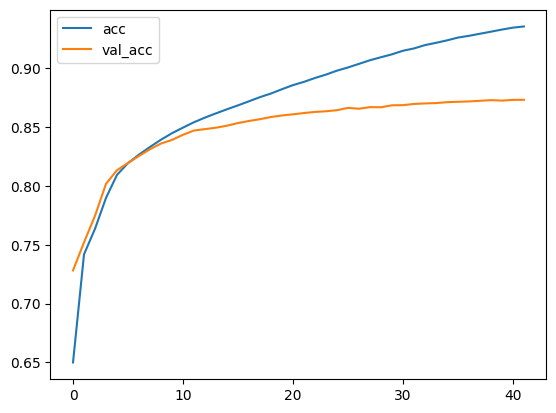

In [ ]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history[['acc', 'val_acc']].plot()

<Axes: >

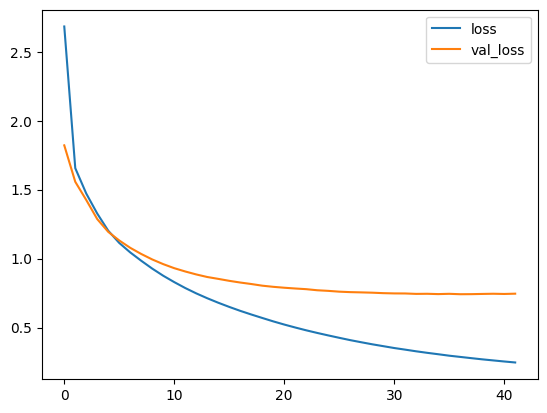

In [ ]:
df_history[['loss', 'val_loss']].plot()

## 3. seq2seq 기계 번역기 동작시키기
---
seq2seq는 훈련 과정(교사 강요)과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 수정해야 합니다. 이번에는 번역 단계를 위해 모델을 수정하고 동작시켜보겠습니다.

전체적인 번역 단계를 정리하면 아래와 같습니다.

번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.
인코더의 입, 출력으로 사용하는 encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용합니다. 이렇게 되면 훈련 단계에 encoder_inputs와 encoder_states 사이에 있는 모든 층까지 전부 불러오게 되므로 결과적으로 훈련 단계에서 사용한 인코더를 그대로 재사용하게 됩니다. 이어서 디코더를 설계합니다. 테스트 단계에서는 디코더를 매 시점 별로 컨트롤 할 예정으로, 이를 위해서 이전 시점의 상태를 저장할 텐서인 decoder_state_input_h, decoder_state_input_c를 정의합니다. 매 시점 별로 디코더를 컨트롤하는 함수는 뒤에서 정의할 decode_sequence()로 해당 함수를 자세히 살펴봐야 합니다.

In [ ]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 64)       │        299,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None, 64)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, None, 64)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, None)           │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 64), (None,    │         33,024 │ masking[0][0],         │
│                           │ 64), (None, 64)]       │                │ any[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 332,096 (1.27 MB)

 Trainable params: 332,096 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hidden_units

64

In [ ]:
# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서 (빈 텐서)
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_states_inputs  # hidden과 cell의 리스트

[<KerasTensor shape=(None, 64), dtype=float32, sparse=None, name=keras_tensor_17>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=None, name=keras_tensor_18>]

In [ ]:
# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)
dec_emb2

<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_19>

In [ ]:
# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용 (Context Vectors)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_states2

[<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_22>]

In [ ]:
# 모든 시점에 대해서 단어 예측 ()
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_outputs2

<KerasTensor shape=(None, None, 8513), dtype=float32, sparse=False, name=keras_tensor_23>

In [ ]:
# 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
decoder_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 64)       │        544,832 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 64),     │         33,024 │ embedding_1[1][0],     │
│                           │ (None, 64), (None,     │                │ input_layer_2[0][0],   │
│                           │ 64)]                   │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 8513)     │        553,345 │ lstm_1[1][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,131,201 (4.32 MB)

 Trainable params: 1,131,201 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. 이 두 개의 값을 states_value에 저장합니다. 그리고 디코더의 초기 입력으로 <SOS>를 준비합니다. 이를 target_seq에 저장합니다. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 이제 디코더는 현재 시점에 대해서 예측을 하게 되는데, 현재 시점의 예측 벡터가 output_tokens, 현재 시점의 은닉 상태가 h, 현재 시점의 셀 상태가 c입니다. 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 그리고 while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다. 각 시점마다 번역된 다어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq, verbose=0)

    # <SOS>에 해당하는 정수 생성 (시작토큰 <sos>를 입력으로 준비)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # 예측 결과를 단어로 변환
        print(output_tokens.shape, output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])   # 가장 확률이 높은 단어의 인덱스
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
            len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

결과 확인을 위한 함수를 만듭니다. seq_to_src 함수는 영어 문장에 해당하는 정수 시퀀스를 입력받으면 정수로부터 영어 단어를 리턴하는 index_to_src를 통해 영어 문장으로 변환합니다. seq_to_tar은 프랑스어에 해당하는 정수 시퀀스를 입력받으면 정수로부터 프랑스어 단어를 리턴하는 index_to_tar을 통해 프랑스어 문장으로 변환합니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if encoded_word != 0:
            sentence = sentence + index_to_src[encoded_word] + ' '
    return sentence

In [ ]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word!=0 and encoded_word!=tar_to_index['<sos>'] and encoded_word!=tar_to_index['<eos>']):
            sentence = sentence + index_to_tar[encoded_word] + ' '
    return sentence

훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해봅시다.

In [ ]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
    print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
    print(input_seq)
    print("번역문장 :",decoded_sentence[1:-5])
    print("-" * 50)

[array([[ 0.99685067,  0.9811259 ,  0.94200927, -0.03379567, -0.72628164,
        -0.50984395,  0.22294469, -0.90463257,  0.6283967 ,  0.89127755,
        -0.12029229, -0.9673277 ,  0.83897644, -0.77109325, -0.7052424 ,
         0.05329338, -0.84666425,  0.00732911,  0.10647842,  0.66519547,
         0.06504715,  0.9058435 , -0.86640656,  0.90699095,  0.03725362,
        -0.86476195, -0.20301175,  0.22108227,  0.3725791 , -0.9074348 ,
         0.37654868,  0.9458345 ,  0.60852104,  0.740507  ,  0.39484388,
        -0.86714566, -0.20168722, -0.1282804 ,  0.95661217, -0.8718982 ,
        -0.7108505 ,  0.99354076,  0.22789317,  0.97628015, -0.03810983,
         0.7290282 ,  0.34348747, -0.6306304 ,  0.586664  ,  0.5655805 ,
         0.1907765 , -0.9391127 , -0.8354502 , -0.1669585 ,  0.98332334,
         0.30248016,  0.99127257, -0.8406708 ,  0.85060465, -0.47478193,
         0.7115866 , -0.59354055,  0.5455029 ,  0.15416968]],
      dtype=float32), array([[ 4.3081512 ,  2.4865296 ,  3.05

테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해봅시다.

In [ ]:
for seq_index in [3,50,100,300,1001, 2000, 3000]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("입력문장 :", seq_to_src(encoder_input_test[seq_index]))
    print("정답문장 :", seq_to_tar(decoder_input_test[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-" * 50)

(1, 1, 8513) [[[7.8308994e-06 2.8755196e-07 7.0979286e-12 ... 2.0524239e-15
   1.5304873e-10 2.3023377e-13]]]
(1, 1, 8513) [[[5.7611337e-06 1.5984701e-04 3.8158410e-10 ... 1.0024021e-11
   2.7270404e-12 2.4037929e-08]]]
(1, 1, 8513) [[[6.6176763e-06 2.4752915e-06 1.1987294e-10 ... 6.1343181e-11
   1.3270171e-10 2.0739527e-08]]]
(1, 1, 8513) [[[1.6711670e-04 6.2364791e-02 1.4487074e-08 ... 5.4780922e-09
   2.2741604e-08 1.9065469e-08]]]
(1, 1, 8513) [[[2.4523091e-08 9.9874049e-01 1.9385600e-12 ... 1.0766752e-15
   2.3619108e-11 1.2442228e-13]]]
(1, 1, 8513) [[[2.0368804e-08 1.8072475e-06 4.1105614e-13 ... 4.4239141e-17
   2.9548774e-12 5.1527586e-14]]]
입력문장 : i m positive . 
정답문장 : j en suis sûr . 
번역문장 : j en suis certain . 
--------------------------------------------------
(1, 1, 8513) [[[9.1620214e-09 7.7867973e-08 5.7289479e-11 ... 4.0452434e-15
   8.5991454e-09 7.1953247e-15]]]
(1, 1, 8513) [[[1.9010571e-07 3.5060020e-05 2.9514613e-10 ... 1.7198998e-12
   1.0816355e-10 3.5723329e-